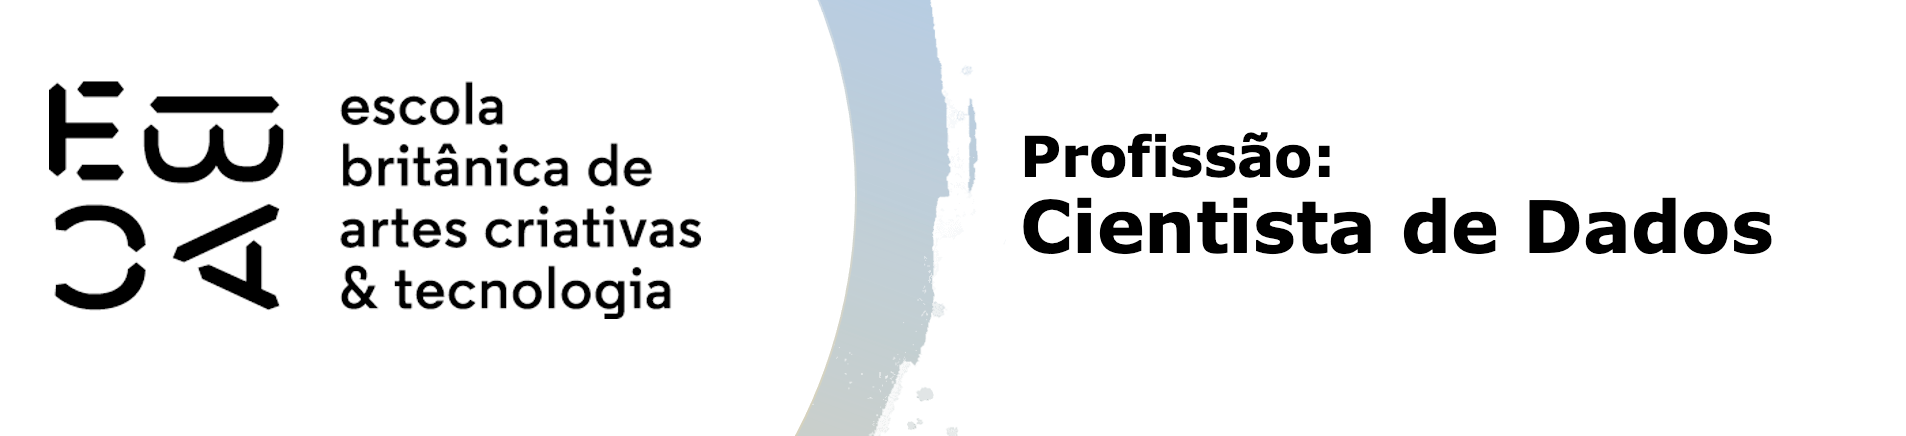

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.stats import ks_2samp
from scipy.stats import t

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
print(df.data_ref.min())
print(df.data_ref.max())

2015-01-01 00:00:00
2016-03-01 00:00:00


In [4]:
ultimos_meses = df['data_ref'].drop_duplicates().nlargest(3)

In [5]:
# criando os dois dataframes
df_oot = df[df['data_ref'].isin(ultimos_meses)]

df_treino = df[~df['data_ref'].isin(ultimos_meses)]

In [6]:

print(f"Tamanho do conjunto de validação (oot): {df_oot.shape[0]}")
print(f"Tamanho do conjunto de treinamento: {df_treino.shape[0]}")

Tamanho do conjunto de validação (oot): 150000
Tamanho do conjunto de treinamento: 600000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Numero de linhas
print(f"Número de linhas: {df.shape[0]}")

Número de linhas: 750000


In [8]:
# numero de linhas pro mes
print(df['data_ref'].value_counts().sort_index())

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [9]:
# analise das variaveis qualitativas
quali = df.select_dtypes(include=['object', 'bool']).columns
for col in quali:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())


Column: sexo
F    504580
M    245420
Name: sexo, dtype: int64

Column: posse_de_veiculo
N    457954
S    292046
Name: posse_de_veiculo, dtype: int64

Column: posse_de_imovel
S    503692
N    246308
Name: posse_de_imovel, dtype: int64

Column: tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: tipo_renda, dtype: int64

Column: educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: educacao, dtype: int64

Column: estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: estado_civil, dtype: int64

Column: tipo_residencia
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290
Name: tipo_residencia, dtype: int64

Column: mau
False    69135

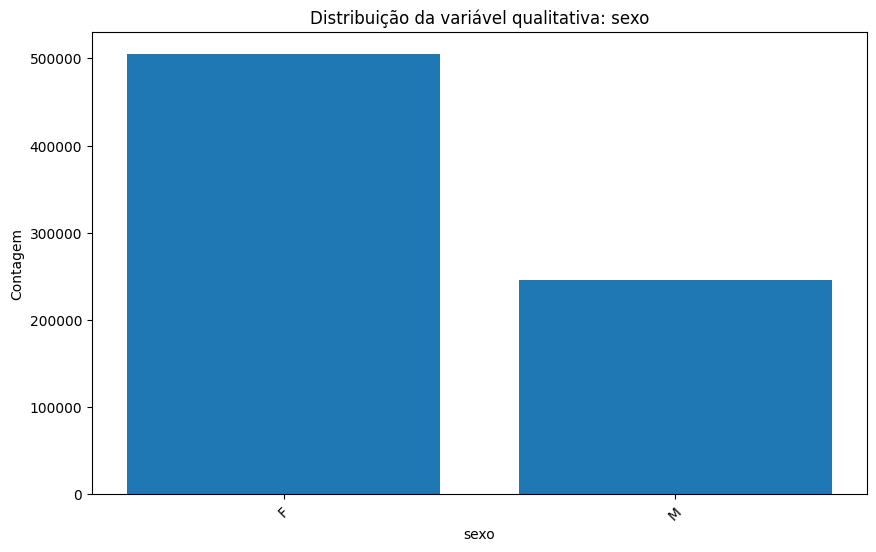

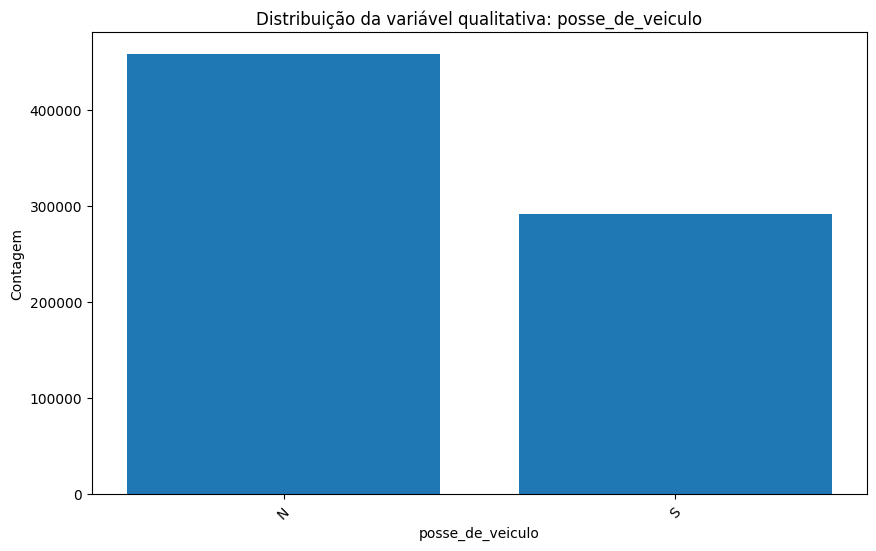

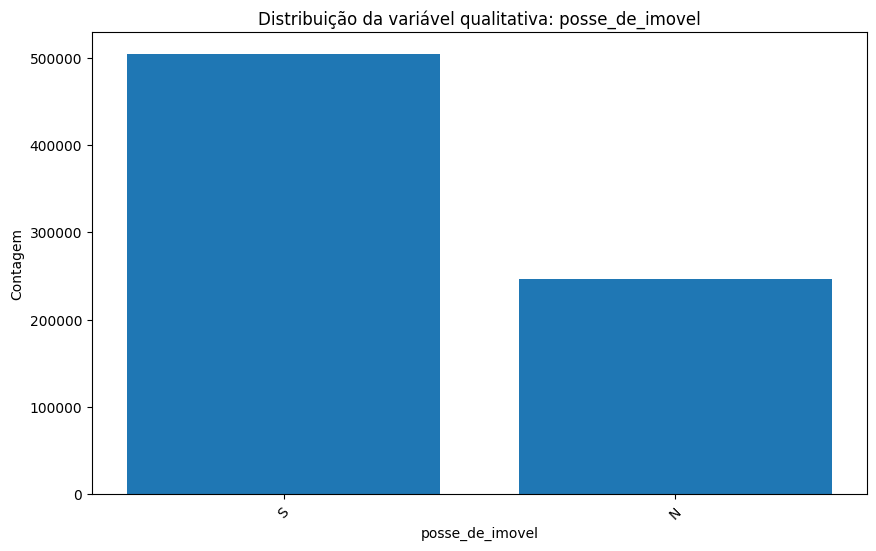

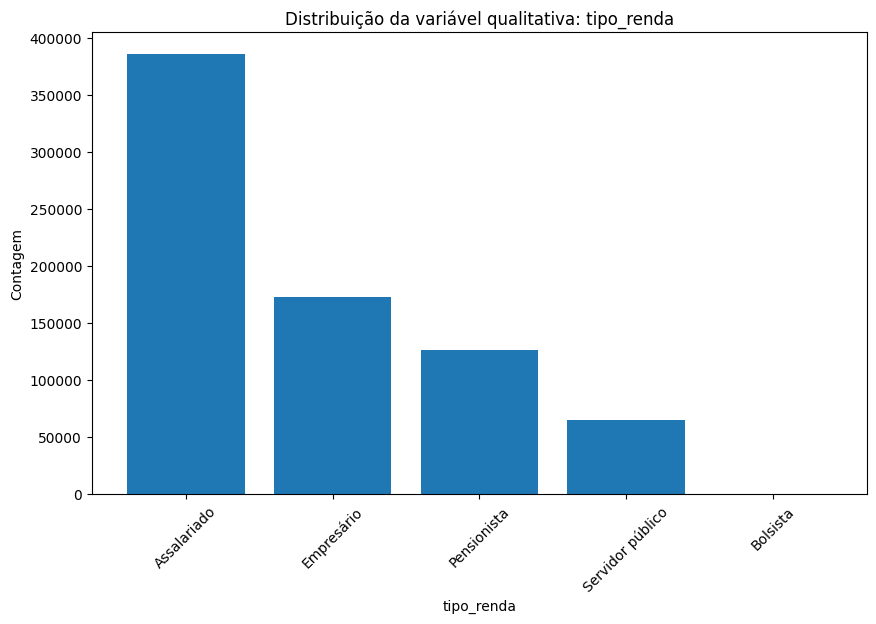

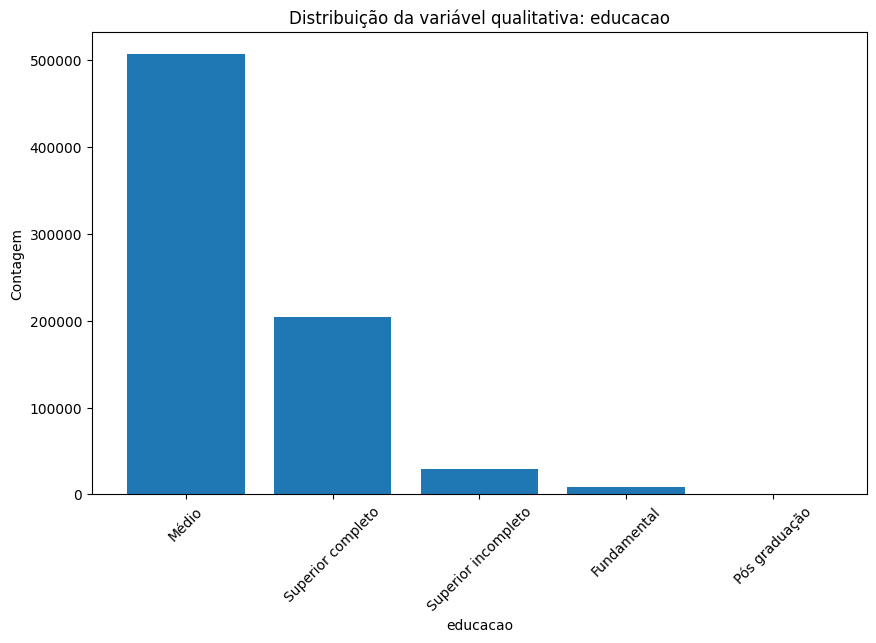

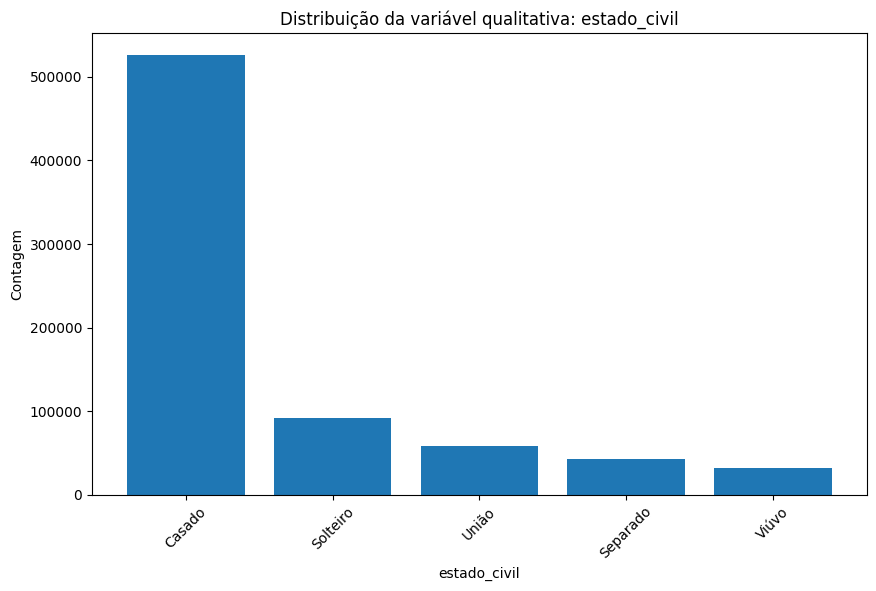

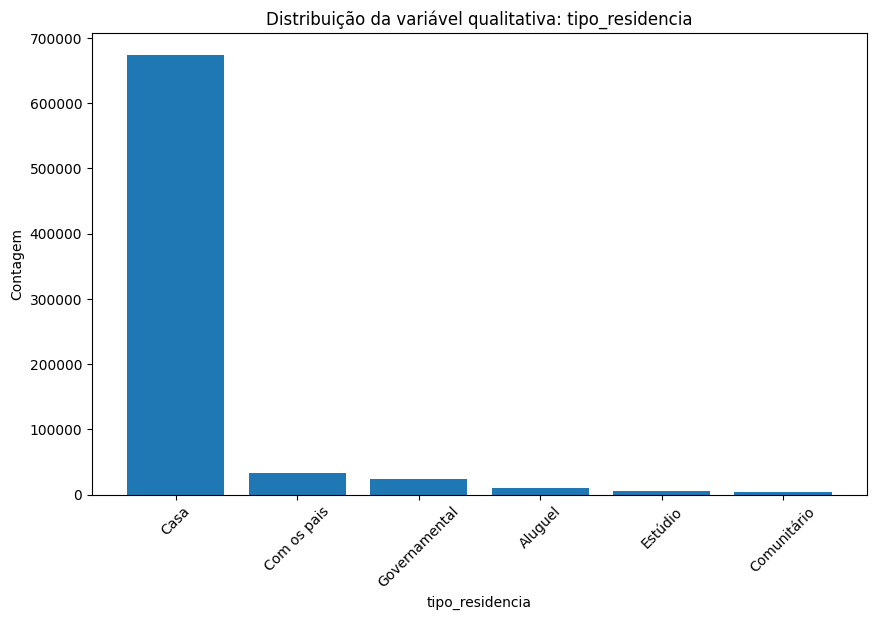

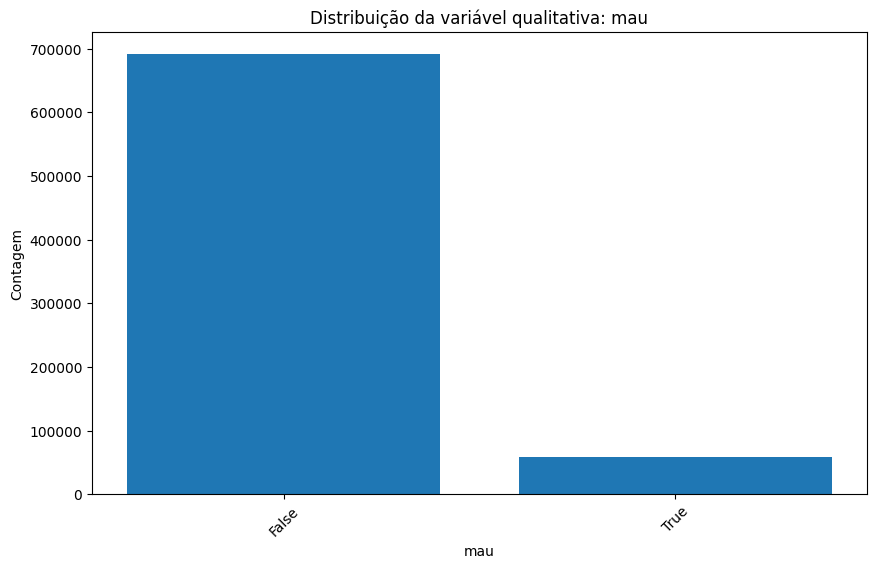

In [10]:
# Gráficos para variáveis qualitativas usando apenas matplotlib
for col in quali:
    counts = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f'Distribuição da variável qualitativa: {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.show()

In [11]:
# analise das variavveis quantitativas
quant= df.select_dtypes(include=['int64', 'float64']).columns
print(df[quant].describe())

               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
max     16649.000000      14.000000      68.000000      42.906849   

       qt_pessoas_residencia         renda  
count          750000.000000  7.500000e+05  
mean                2.212241  2.323854e+04  
std                 0.903428  7.910601e+04  
min                 1.000000  1.076700e+02  
25%                 2.000000  3.467700e+03  
50%                 2.000000  7.861820e+03  
75%                 3.000000  1.831828e+04  
max               

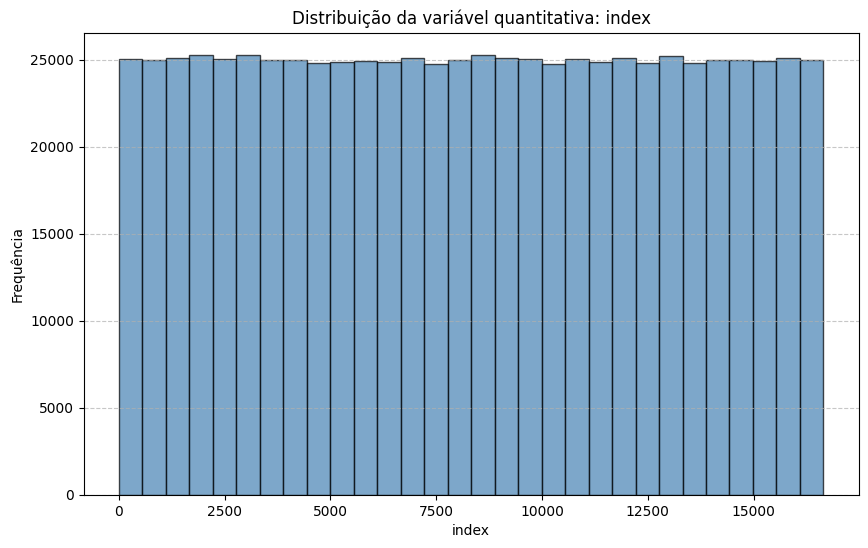

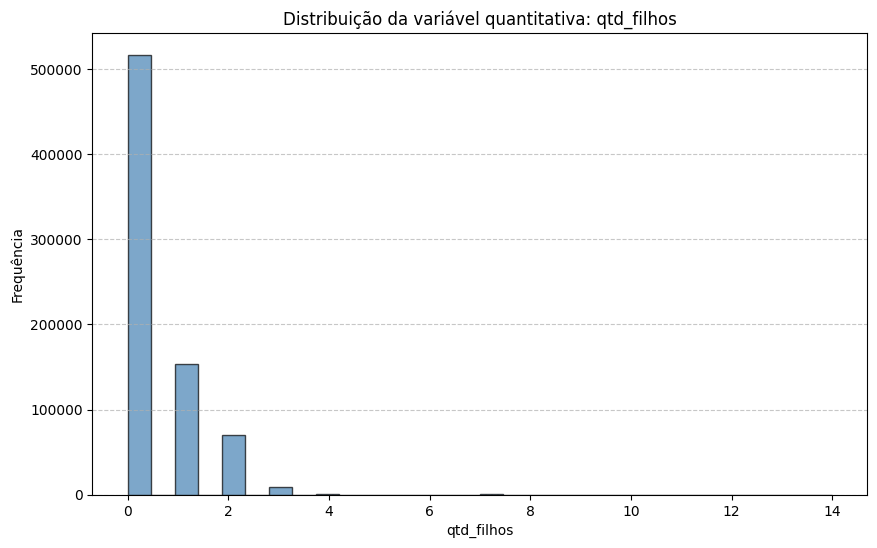

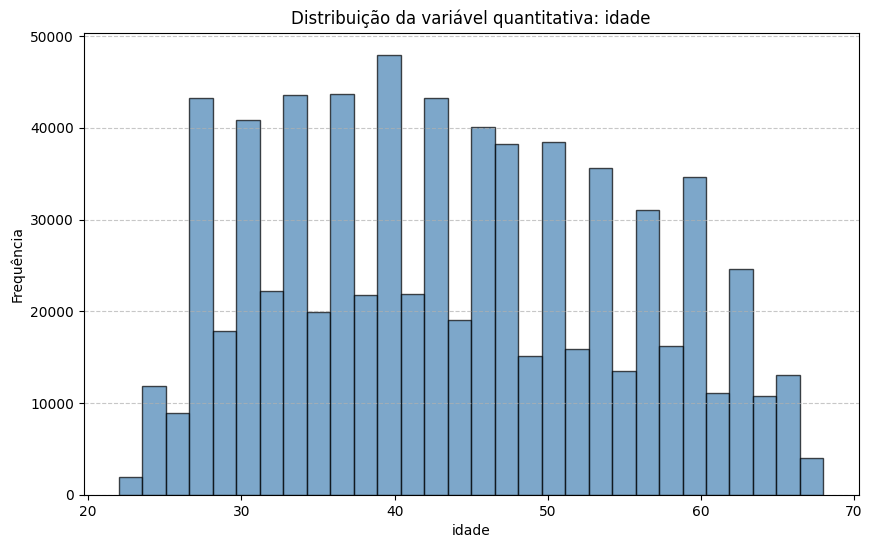

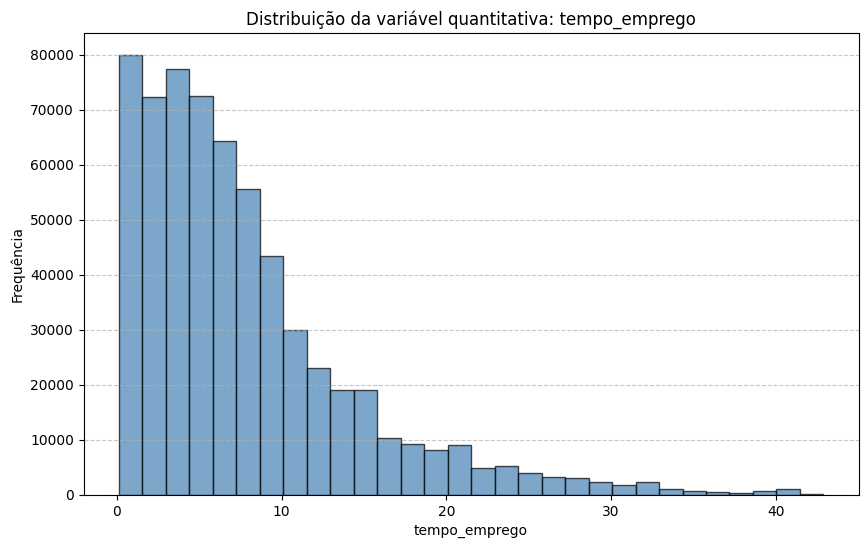

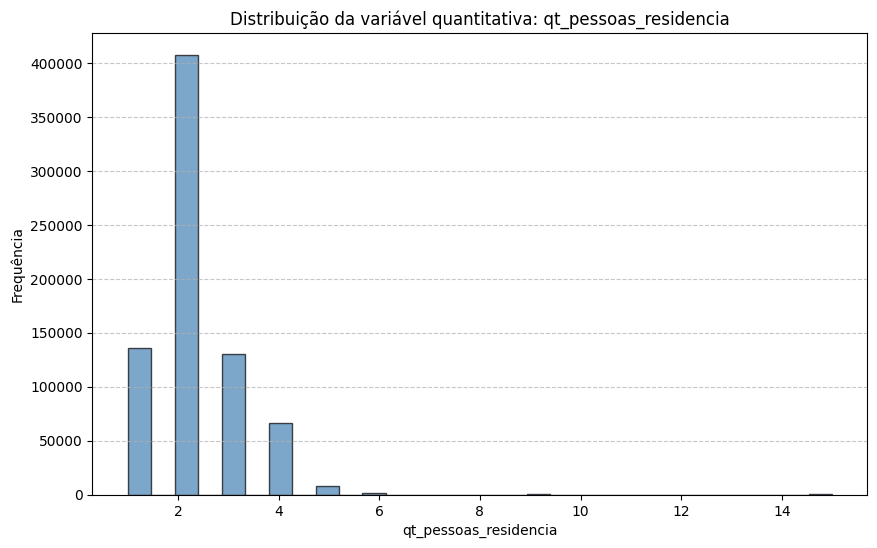

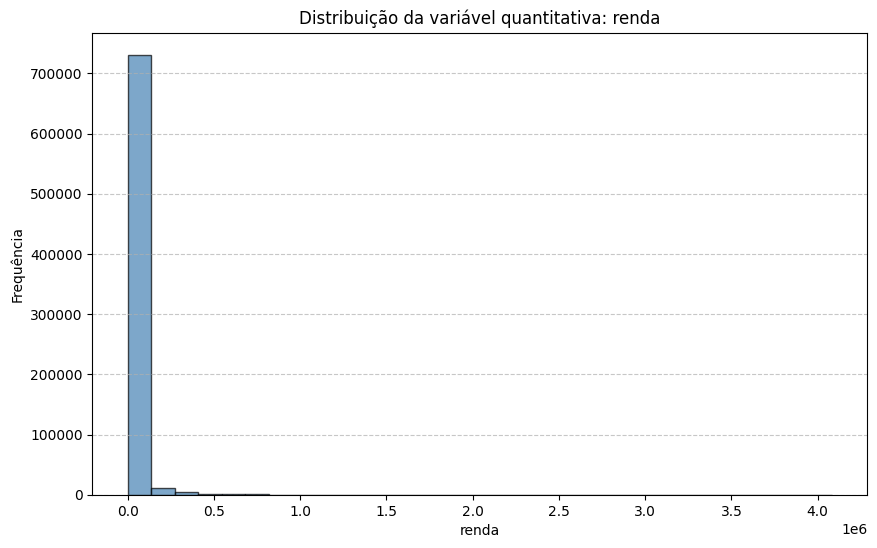

In [12]:
for col in quant:
    plt.figure(figsize=(10, 6))
    plt.hist(df[col].dropna(), bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    plt.title(f'Distribuição da variável quantitativa: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

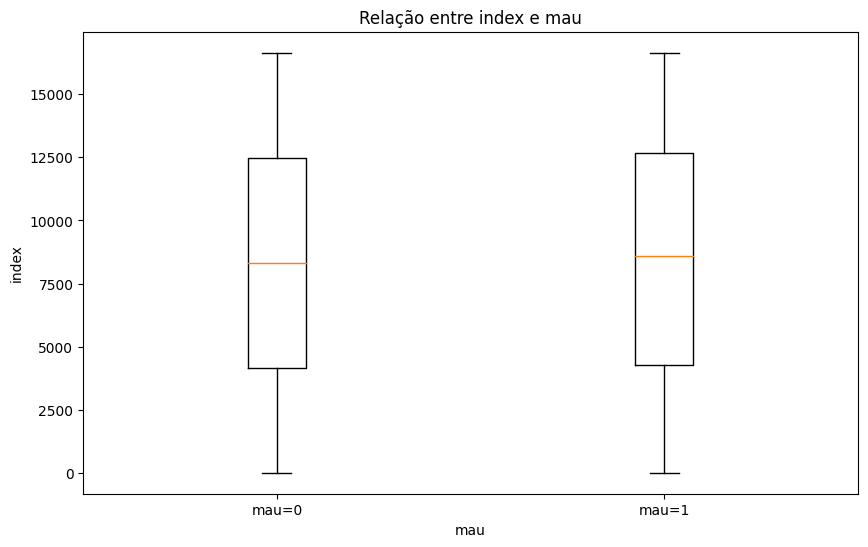

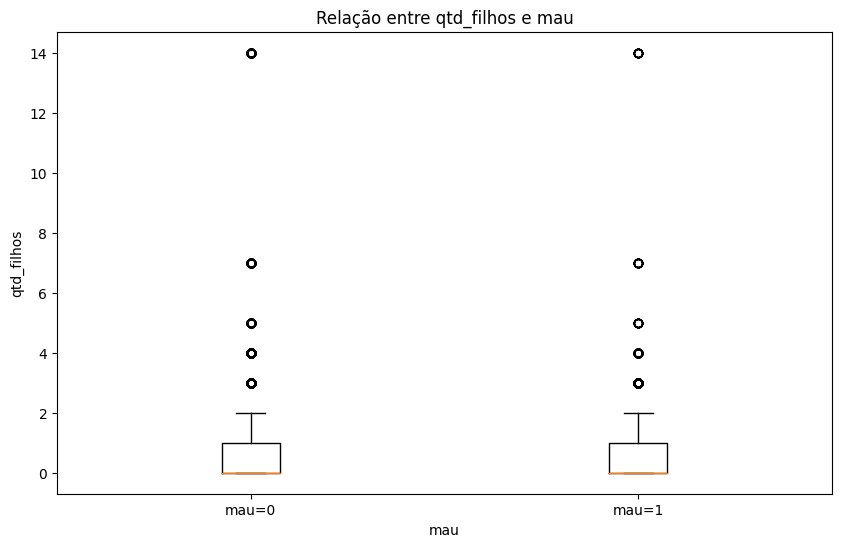

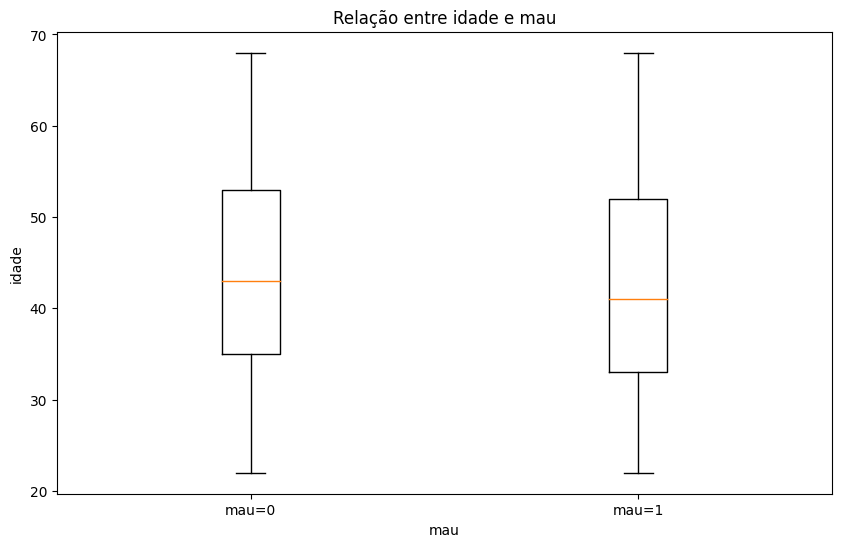

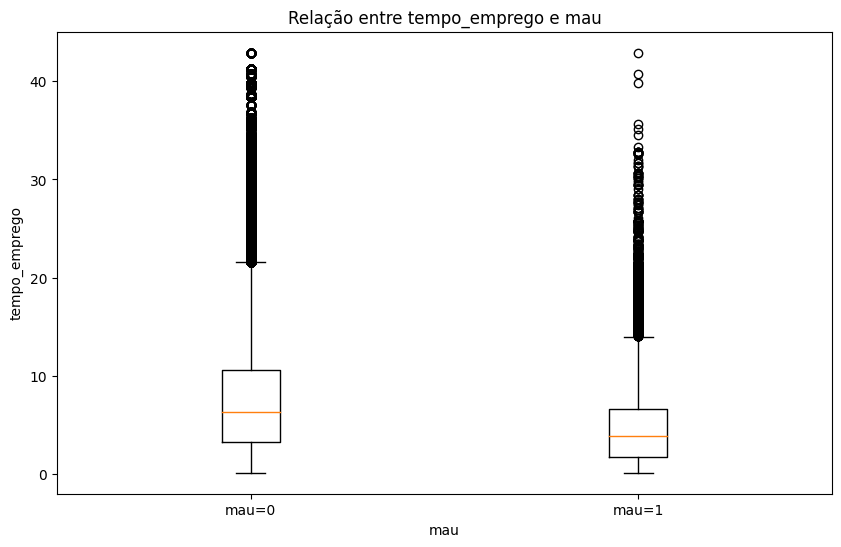

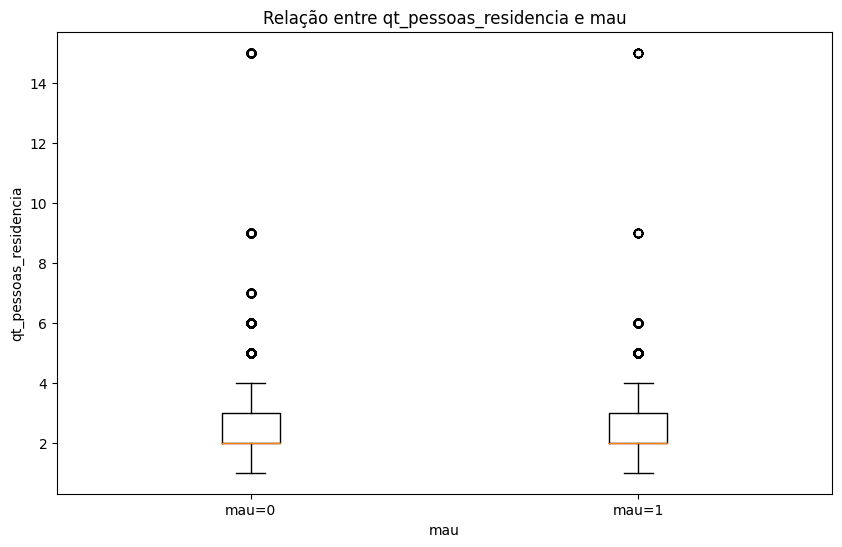

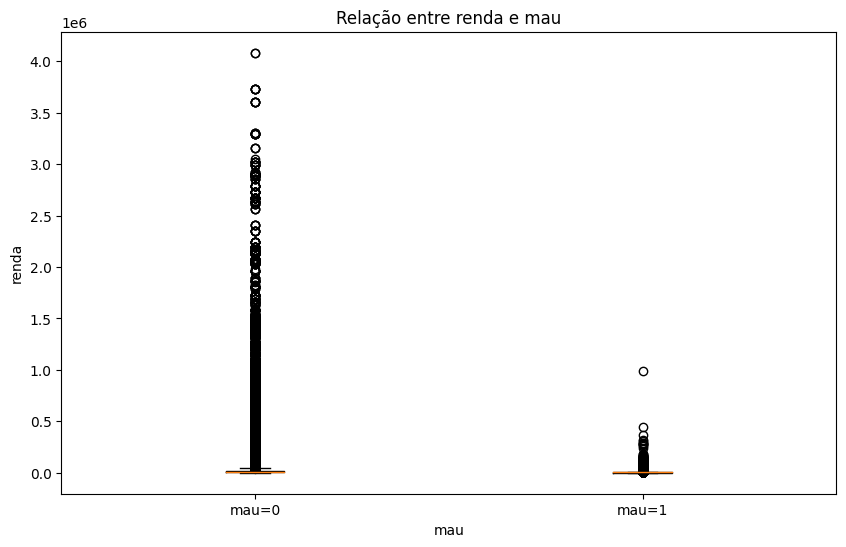

In [13]:
for col in quant:
    plt.figure(figsize=(10, 6))
    data_0 = df[df['mau'] == False][col].dropna()
    data_1 = df[df['mau'] == True][col].dropna()
    plt.boxplot([data_0, data_1], labels=['mau=0', 'mau=1'])
    plt.title(f'Relação entre {col} e mau')
    plt.xlabel('mau')
    plt.ylabel(col)
    plt.show()

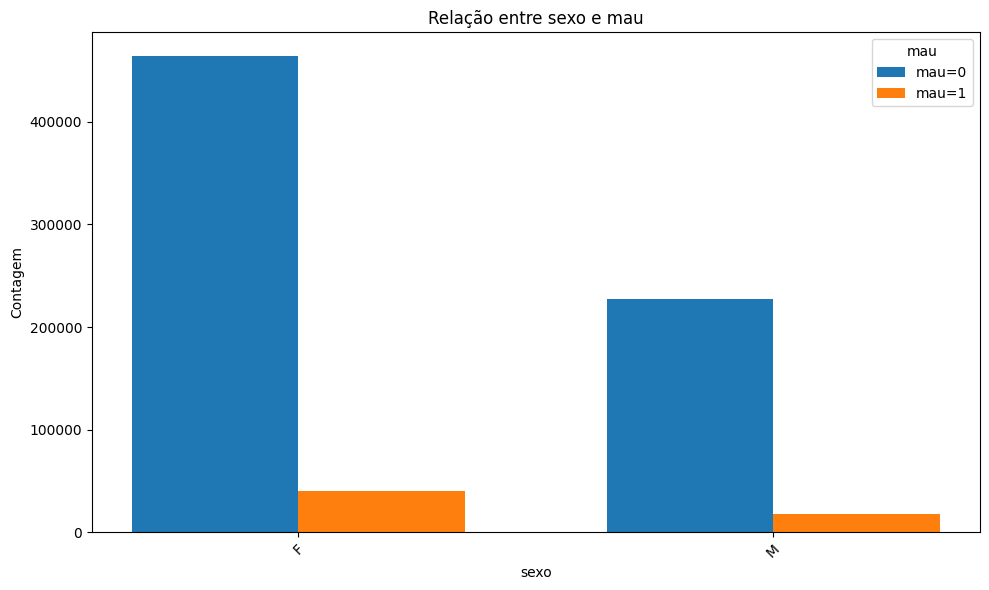

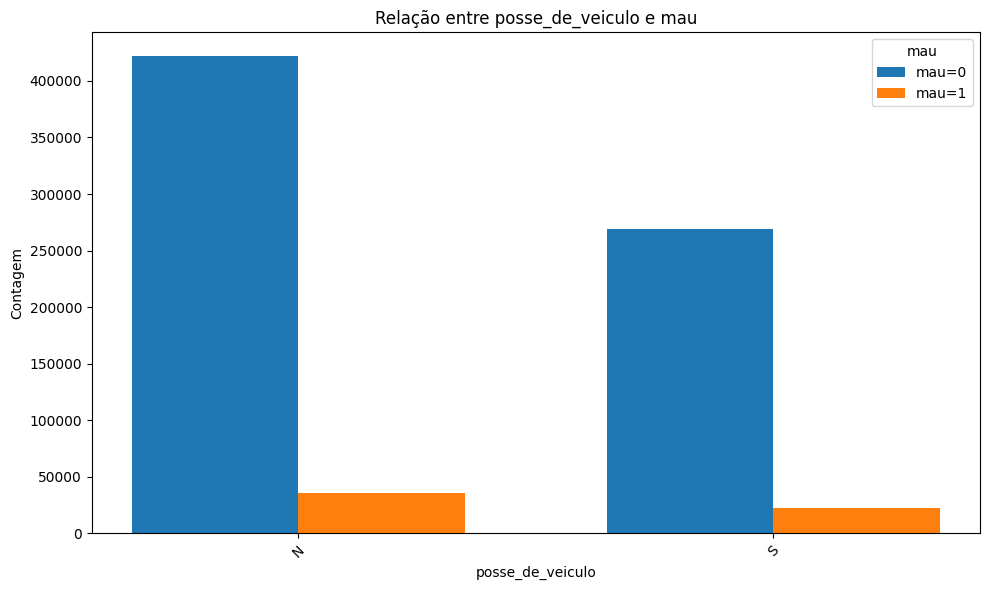

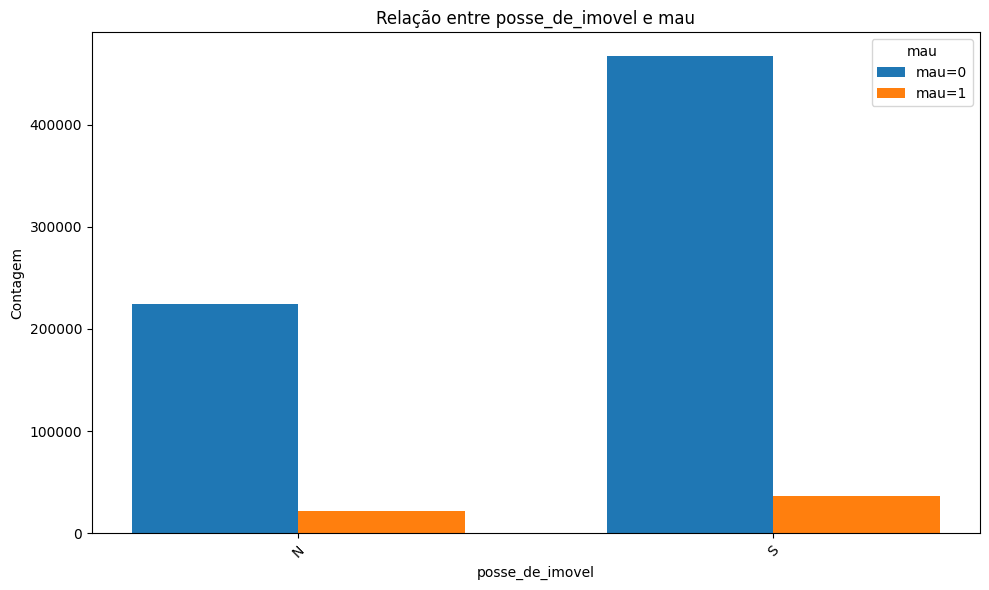

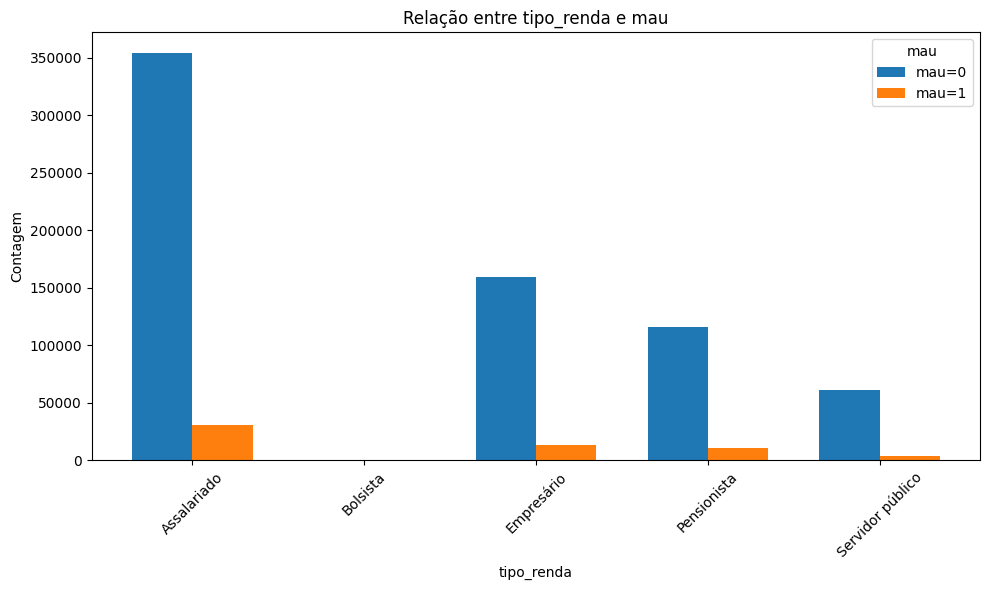

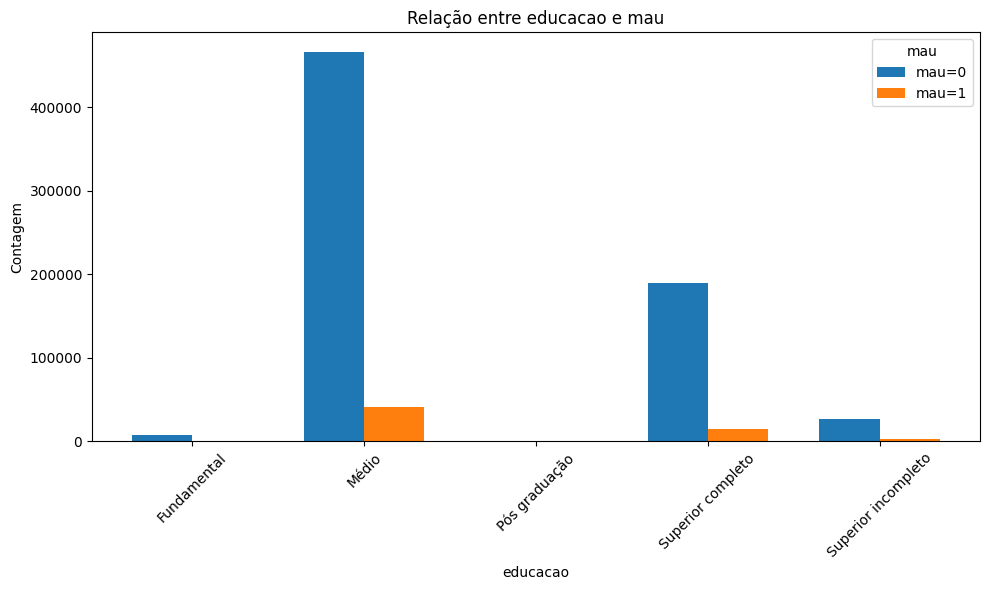

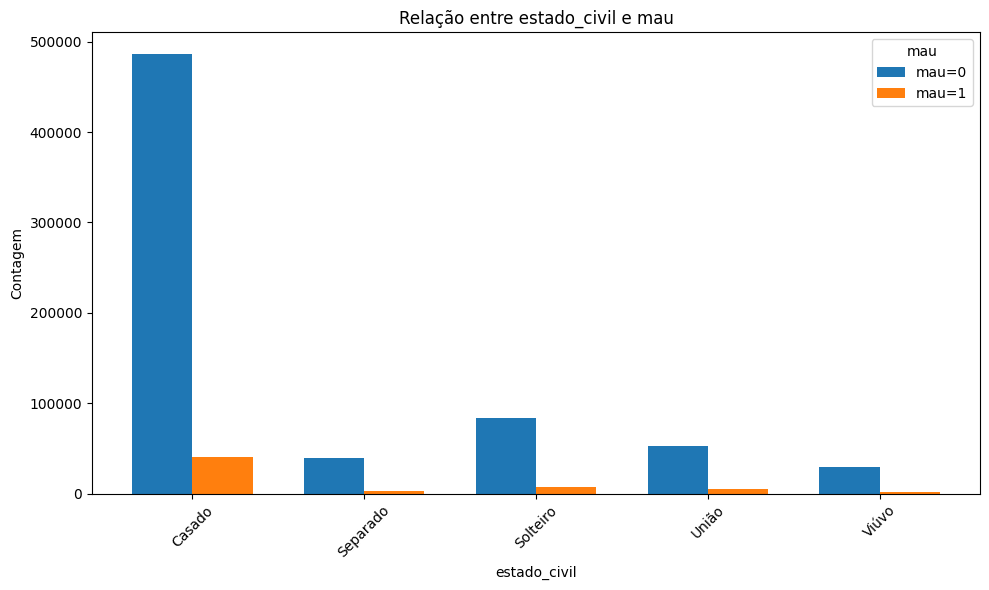

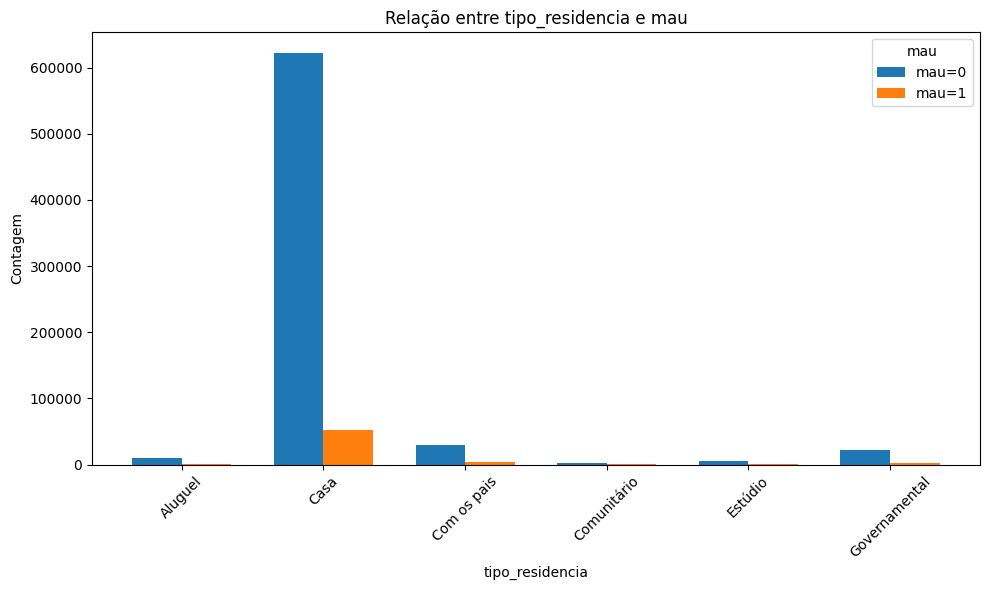

In [14]:
# qualitativas
for col in quali:
    if col != 'mau':
        counts_0 = df[df['mau'] == False][col].value_counts().sort_index()
        counts_1 = df[df['mau'] == True][col].value_counts().sort_index()
        categories = sorted(set(counts_0.index).union(set(counts_1.index)))
        values_0 = [counts_0.get(cat, 0) for cat in categories]
        values_1 = [counts_1.get(cat, 0) for cat in categories]

        x = range(len(categories))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar([i - width/2 for i in x], values_0, width=width, label='mau=0')
        plt.bar([i + width/2 for i in x], values_1, width=width, label='mau=1')
        plt.title(f'Relação entre {col} e mau')
        plt.xlabel(col)
        plt.ylabel('Contagem')
        plt.xticks(x, categories, rotation=45)
        plt.legend(title='mau', loc='upper right')
        plt.tight_layout()
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [15]:
df_treino.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [16]:
# substituindo missing por media
df_treino['tempo_emprego'].fillna(df_treino['tempo_emprego'].mean(), inplace=True)

In [17]:
df_treino.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [18]:
# Identificando outliers com IQR
outlier = []
for col in quant:
    Q1 = df_treino[col].quantile(0.25)
    Q3 = df_treino[col].quantile(0.75)
    IQR = Q3 - Q1
    inferior = Q1 - 1.5 * IQR
    superior = Q3 + 1.5 * IQR
    outliers = df_treino[(df_treino[col] < inferior) | (df_treino[col] > superior)]
    if not outliers.empty:
        outlier.append(col)

In [19]:
print(f"Variáveis com possíveis outliers: {outlier}")

Variáveis com possíveis outliers: ['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


In [20]:
# Tratando os outliers
df_treino['renda'] = np.clip(df_treino['renda'], a_min=None, a_max=df_treino['renda'].quantile(0.99))
df_treino['qt_pessoas_residencia'] = np.clip(df_treino['qt_pessoas_residencia'], a_min=None, a_max=df_treino['qt_pessoas_residencia'].quantile(0.99))
df_treino['tempo_emprego'] = np.clip(df_treino['tempo_emprego'], a_min=None, a_max=df_treino['tempo_emprego'].quantile(0.99))
df_treino['qtd_filhos'] = np.clip(df_treino['qtd_filhos'], a_min=None, a_max=df_treino['qtd_filhos'].quantile(0.99))

In [21]:
# agrupando categorias raras
df_treino['educacao'] = df_treino['educacao'].replace(['Superior incompleto', 'Médio incompleto'], 'Outros')
df_treino['estado_civil'] = df_treino['estado_civil'].replace(['Separado', 'Viúvo', 'União'], 'Outros')
df_treino['tipo_renda'] = df_treino['tipo_renda'].replace(['Pensionista', 'Bolsista'], 'Outros')
df_treino['tipo_residencia'] = df_treino['tipo_residencia'].replace(['Comunitário', 'Aluguel', 'Estúdio'], 'Outros')

In [22]:
df_treino['mau'] = df_treino['mau'].astype(int)

In [23]:
# treinando modelo
modelo = smf.logit(formula='''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
''', data=df_treino).fit()

Optimization terminated successfully.
         Current function value: 0.208003
         Iterations 10


In [24]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599980
Method:                           MLE   Df Model:                           19
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.09527
Time:                        09:17:27   Log-Likelihood:            -1.2480e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4567      0.058    -25.058      0.000      -1.571      -1.343
sexo[T.M]                           -0.1233      0.013     -9.404      0.000      -0.149      -0.098
posse_de_veiculo[T.S]                0.0311      0.012      2.511      0.012       0.007       0.055
posse_de_imovel[T.S]                -0.0853      0.012     -7.217      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0509      0.014     -3.639      0.000      -0.078      -0.023
tipo_renda[T.Outros]                -0.0433      0.020     -2.151      0.031      -0.083      -0.004
tipo_renda[T.Servidor público]      -0.0322      0.023     -1.386      0.166      -0.078       0.013
educacao[T.Médio]                   -0.0270      0.049     -0.556      0.578      -0.122       0.068
educacao[T.Outros]                  -0.0779      0.056     -1.400      0.162      -0.187       0.031
educacao[T.Pós graduação]           -0.0421      0.168     -0.251      0.802      -0.371       0.287
educacao[T.Superior completo]       -0.0872      0.050     -1.755      0.079      -0.185       0.010
estado_civil[T.Outros]               0.0269      0.015      1.828      0.068      -0.002       0.056
estado_civil[T.Solteiro]             0.0067      0.017      0.386      0.699      -0.027       0.041
tipo_residencia[T.Com os pais]       0.0150      0.025      0.595      0.552      -0.034       0.064
tipo_residencia[T.Governamental]     0.0023      0.031      0.072      0.942      -0.059       0.064
tipo_residencia[T.Outros]            0.0537      0.034      1.575      0.115      -0.013       0.120
qtd_filhos                           0.0022      0.008      0.257      0.797      -0.014       0.019
idade                               -0.0001      0.001     -0.191      0.849      -0.002       0.001
tempo_emprego                       -0.0231      0.002    -12.832      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -94.062      0.000      -0.000      -0.000
====================================================================================================
"""

In [25]:
modelo_2 = smf.logit(formula='''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + tipo_renda +
    tempo_emprego + renda''', data=df_treino).fit()

Optimization terminated successfully.
         Current function value: 0.208027
         Iterations 10


In [26]:
modelo_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599991
Method:                           MLE   Df Model:                            8
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.09517
Time:                        09:17:35   Log-Likelihood:            -1.2482e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.4918      0.015   -102.428      0.000      -1.520      -1.463
sexo[T.M]                         -0.1199      0.013     -9.248      0.000      -0.145      -0.094
posse_de_veiculo[T.S]              0.0231      0.012      1.901      0.057      -0.001       0.047
posse_de_imovel[T.S]              -0.0865      0.011     -7.524      0.000      -0.109      -0.064
tipo_renda[T.Empresário]          -0.0583      0.014     -4.203      0.000      -0.086      -0.031
tipo_renda[T.Outros]              -0.0410      0.016     -2.514      0.012      -0.073      -0.009
tipo_renda[T.Servidor público]    -0.0447      0.023     -1.939      0.052      -0.090       0.000
tempo_emprego                     -0.0230      0.002    -12.854      0.000      -0.026      -0.019
renda                             -0.0001   1.09e-06    -94.422      0.000      -0.000      -0.000
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [27]:
# Funçao para calcular o ks
def calcula_ks(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return max(tpr - fpr)

In [28]:
# Função para calcular o Gini
def calcula_gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

In [29]:
df_treino['pred_prob'] = modelo_2.predict(df_treino)
df_treino['pred_class'] = (df_treino['pred_prob'] >= 0.5).astype(int)

In [30]:

acuracia_treino = accuracy_score(df_treino['mau'], df_treino['pred_class'])
ks_treino = calcula_ks(df_treino['mau'], df_treino['pred_prob'])
gini_treino = calcula_gini(df_treino['mau'], df_treino['pred_prob'])

In [31]:
print(f"Treino -  Accuracy: {acuracia_treino:.2f}, KS: {ks_treino:.2f}, Gini: {gini_treino:.2f}")

Treino -  Accuracy: 0.94, KS: 0.39, Gini: 0.53


In [32]:
# agrupando categorias raras no teste
df_oot['educacao'] = df_oot['educacao'].replace(['Superior incompleto', 'Médio incompleto'], 'Outros')
df_oot['estado_civil'] = df_oot['estado_civil'].replace(['Separado', 'Viúvo', 'União'], 'Outros')
df_oot['tipo_renda'] = df_oot['tipo_renda'].replace(['Pensionista', 'Bolsista'], 'Outros')
df_oot['tipo_residencia'] = df_oot['tipo_residencia'].replace(['Comunitário', 'Aluguel', 'Estúdio'], 'Outros')

In [33]:
df_oot['mau'] = df_oot['mau'].astype(int)

In [34]:
# Gera as probabilidades previstas para o conjunto oot
df_oot['pred_prob'] = modelo_2.predict(df_oot)

In [35]:
# Remove linhas com valores ausentes em 'mau' ou 'pred_prob'
df_oot = df_oot.dropna(subset=['mau', 'pred_prob'])

In [36]:
# Evaluate on out-of-time dataset
df_oot['pred_prob'] = modelo_2.predict(df_oot)
df_oot['pred_class'] = (df_oot['pred_prob'] >= 0.5).astype(int)

In [37]:
acuracia_oot = accuracy_score(df_oot['mau'], df_oot['pred_class'])
ks_oot = calcula_ks(df_oot['mau'], df_oot['pred_prob'])
gini_oot = calcula_gini(df_oot['mau'], df_oot['pred_prob'])

In [38]:
print(f"Teste out of time - Accuracy: {acuracia_oot:.2f}, KS: {ks_oot:.2f}, Gini: {gini_oot:.2f}")

Teste out of time - Accuracy: 0.86, KS: 0.35, Gini: 0.47


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

In [39]:
# Verificando nulos na base
nulos = df.isnull().sum()
print(nulos[nulos > 0])


tempo_emprego    125957
dtype: int64


In [40]:
# Identificando o tipo das variáveis com nulos
tipos_nulos = df.dtypes[nulos > 0]
print(tipos_nulos)

tempo_emprego    float64
dtype: object


In [41]:
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)

In [42]:
df.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

In [43]:
# Identificando outliers
outliers_dict = {}
for col in quant:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    inferior = Q1 - 1.5 * IQR
    superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < inferior) | (df[col] > superior)]
    if not outliers.empty:
        outliers_dict[col] = outliers.shape[0]

print("Quantidade de outliers por variável:")
for k, v in outliers_dict.items():
    print(f"{k}: {v}")

Quantidade de outliers por variável:
qtd_filhos: 10016
tempo_emprego: 57123
qt_pessoas_residencia: 9629
renda: 79072


In [44]:
# Tratando os outliers
for col in outlier:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    inferior = Q1 - 1.5 * IQR
    superior = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], inferior, superior)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleciona apenas as variáveis quantitativas para o PCA
quant_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Remove possíveis nulos antes do PCA
df_pca = df[quant_vars].dropna()

# Padroniza os dados antes do PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# Aplica o PCA para 5 componentes
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Cria um DataFrame com os componentes principais
df_pca_result = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)], index=df_pca.index)
df_pca_result.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.988244,-1.127542,-0.335208,-0.599455,0.532519
1,0.120125,-1.171065,-0.638811,-0.320932,-0.302590
2,3.629426,-0.536682,0.458496,0.421370,0.126766
3,-1.198476,0.666243,0.572914,-0.628438,-0.234533
4,-0.601716,-0.973596,-1.253449,-1.086226,0.497078


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [46]:
# Aplicando get_dummies nas colunas categóricas
categoricas = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

df_dummies = pd.get_dummies(df, columns=categoricas, drop_first=True)
df_dummies.head()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,5733,0.0,43,6.873973,1.0,2515.39,False,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2015-01-01,727,0.0,35,4.526027,2.0,3180.19,False,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2015-01-01,6374,2.0,31,0.243836,4.0,1582.29,False,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2015-01-01,9566,0.0,54,12.772603,2.0,13721.17,False,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2015-01-01,9502,0.0,31,8.432877,1.0,2891.08,False,0,1,...,1,0,1,0,0,1,0,0,0,0


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# removção de outliers
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds[col] = (lower, upper)
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            lower, upper = self.bounds[col]
            X_[col] = X_[col].clip(lower, upper)
        return X_

# separando categoricas e quantitativas
quant_cols = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
cat_cols = ['posse_de_veiculo']

# Pipeline para quantitativas: impute, clip outliers, scale, PCA
quant_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier', OutlierClipper(columns=quant_cols)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

# Pipeline para categoricass: get dummies (one-hot)
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# combinando os pipelines
preprocessamento = ColumnTransformer([
    ('quant', quant_pipeline, quant_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Exemplo de uso:
# X = df[quant_cols + cat_cols]
# X_proc = preprocessamento.fit_transform(X)

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [48]:
from pycaret.classification import *

# Seleciona apenas as colunas relevantes para modelagem
colunas_modelo = [
    'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
    'educacao', 'estado_civil', 'tipo_residencia', 'mau'
]

In [49]:
# Cria um novo DataFrame apenas com as colunas necessárias
df_pycaret = df[colunas_modelo].copy()

In [50]:
# Setup do PyCaret
clf1 = setup(
    data=df_pycaret,
    target='mau',
    session_id=123,
    categorical_features=[
        'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
        'educacao', 'estado_civil', 'tipo_residencia'
    ],
    numeric_features=[
        'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'
    ],
    imputation_type='simple',
    fix_imbalance=True,
    verbose=False,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95
)

In [51]:
# Cria e treina o modelo LightGBM
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9041,0.7690,0.2078,0.3237,0.2531,0.2045,0.2102
1,0.9058,0.7864,0.2241,0.3432,0.2711,0.2232,0.2290
2,0.9038,0.7786,0.2124,0.3239,0.2566,0.2075,0.2128
3,0.9055,0.7801,0.2122,0.3355,0.2600,0.2122,0.2186
4,0.9053,0.7830,0.2222,0.3390,0.2684,0.2202,0.2258
5,0.9070,0.7751,0.2185,0.3486,0.2686,0.2218,0.2287
6,0.9062,0.7823,0.2251,0.3462,0.2728,0.2251,0.2310
7,0.9052,0.7776,0.2180,0.3360,0.2644,0.2162,0.2220
8,0.9071,0.7774,0.2124,0.3469,0.2635,0.2170,0.2244


In [52]:
# Avalia o modelo com gráficos
evaluate_model(lgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [53]:
# Exibe o pipeline completo de transformação
print(get_config('pipeline'))

Pipeline(memory=FastMemory(location=C:\Users\MARKET~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mea...
                                                              return_df=True,
                                                         

### Treinar um modelo de regressão logistica com o resultado

In [54]:
from sklearn.linear_model import LogisticRegression

# Seleciona as features principais do PCA e a dummy de posse_de_veiculo
X = np.hstack([df_pca_result.values, pd.get_dummies(df['posse_de_veiculo'], drop_first=True).values])
y = df['mau'].astype(int).values

# Treina o modelo de regressão logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

# Exibe os coeficientes
print("Coeficientes do modelo:", logreg.coef_)
print("Intercepto:", logreg.intercept_)

Coeficientes do modelo: [[ 0.36599831 -1.29162596  0.63462805 -1.12733179 -0.00149325 -0.01806287]]
Intercepto: [-3.31965988]


In [57]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Avaliando a regressão logística treinada (logreg) nos dados usados para treino

# Predição das probabilidades e classes
y_pred_prob = logreg.predict_proba(X)[:, 1]
y_pred_class = logreg.predict(X)

# Métricas
acc = accuracy_score(y, y_pred_class)
roc_auc = roc_auc_score(y, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
ks = max(tpr - fpr)
gini = 2 * roc_auc - 1

print(f"Acurácia: {acc:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"KS: {ks:.3f}")
print(f"Gini: {gini:.3f}")

Acurácia: 0.922
ROC AUC: 0.780
KS: 0.418
Gini: 0.559


### Salvar o pickle file do modelo treinado

In [56]:
import pickle

with open('model_final.pkl', 'wb') as f:
    pickle.dump(logreg, f)

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.